In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas import json_normalize
import pickle
import math
import numpy as np
import os
from datetime import datetime, timedelta
import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from collections import Counter
import warnings
from math import sqrt
warnings.filterwarnings('ignore')

%matplotlib inline  


pd.set_option('max_colwidth', 200)
%config Completer.use_jedi = False




def latexify(fig_width=None, fig_height=None, columns=2):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.32 if columns==1 else 6.75 # width in inches

    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              'text.latex.preamble': [r'\usepackage{gensymb}'],
              'axes.labelsize': 8, # fontsize for x and y labels (was 10)
              'axes.titlesize': 8,
              'font.size': 8, # was 10
              'legend.fontsize': 8, # was 10
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    matplotlib.rcParams.update(params)


def format_axes(ax,twinx=False,SPINE_COLOR="gray"):
    
    if twinx:
        for spine in ['top']:
            ax.spines[spine].set_visible(False)

        for spine in ['left', 'bottom', 'right']:
            ax.spines[spine].set_color(SPINE_COLOR)
            ax.spines[spine].set_linewidth(0.5)
        
    else:
        for spine in ['top', 'right']:
            ax.spines[spine].set_visible(False)

        for spine in ['left', 'bottom']:
            ax.spines[spine].set_color(SPINE_COLOR)
            ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax

## Plot of Number of cities available with time

In [2]:
#load PM2.5 data 2010-2019 (cpcb)
root_path = "../PMdataset/"
df_daily_city_stn = pd.read_csv(root_path+"pm2.5_allcities_groupby_date_city_station_2010_19.csv",index_col=0)
df_daily_city = pd.read_csv(root_path+"pm2.5_allcities_groupby_date_city_2010_19.csv",index_col=0)
df_daily_city

,Unnamed: 0.1,From Date,city,WS,WD,Gust,Variance,AT,RH,SR,...,P_Xylene,O Xylene,ETH,SPM,AP,MH,readings_in_day,total_stations,active_stations,state
0,0,2010-01-01,Agra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,0,Uttar Pradesh
1,1,2010-01-01,Ahmedabad,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,0,Gujarat
2,2,2010-01-01,Ambala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,0,Haryana
3,3,2010-01-01,Ankleshwar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,0,Gujarat
4,4,2010-01-01,Bahadurgarh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,0,Haryana
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202192,202192,2019-04-30,Udaipur,1.017579,253.649263,NaN,NaN,NaN,17.871263,192.898000,...,NaN,3.700211,NaN,NaN,NaN,NaN,94.0,1,1,Rajasthan
202193,202193,2019-04-30,Ujjain,4.636842,255.042105,NaN,NaN,36.660000,18.252632,161.242105,...,NaN,NaN,NaN,NaN,NaN,NaN,95.0,1,1,Madhya Pradesh
202194,202194,2019-04-30,Varanasi,0.801053,180.757895,NaN,NaN,33.582105,23.600000,80.157895,...,NaN,NaN,NaN,NaN,NaN,NaN,71.0,1,1,Uttar Pradesh
202195,202195,2019-04-30,Vijayawada,0.519041,221.018904,NaN,NaN,37.019178,55.307671,228.706154,...,NaN,1.899589,NaN,NaN,NaN,NaN,67.0,1,1,Andhra Pradesh


In [3]:
#load OpenAQ data 2019-2021
root_path = "../PMdataset/"
df_daily_city_stn_oq = pd.read_csv(root_path+"pm2.5_allcities_groupby_date_city_station_2019_21_openaq.csv",index_col=0)
df_daily_city_oq = pd.read_csv(root_path+"pm2.5_allcities_groupby_date_city_2019_21_openaq.csv",index_col=0)
df_daily_city_oq

,From Date,city,PM2_5,readings,total_stations,active_stations
0,2019-01-18,Delhi,133.960000,2.0,1,1
2,2019-04-30,Agra,90.000000,1.0,1,1
3,2019-04-30,Ajmer,105.640000,2.0,1,1
4,2019-04-30,Amaravati,22.000000,1.0,1,1
6,2019-04-30,Amritsar,50.970000,1.0,1,1
...,...,...,...,...,...,...
75127,2021-08-01,Solapur,18.020000,69.0,1,1
75128,2021-12-03,Solapur,NaN,0.0,1,0
75129,2021-12-04,Solapur,NaN,0.0,1,0
75130,2021-12-05,Solapur,14.172069,29.0,1,1


In [4]:
#merge cpcb and openaq 
df_daily_city_merged = pd.concat([df_daily_city,df_daily_city_oq])[["From Date","city",
                                                                    "PM2_5","total_stations","active_stations","state"]]

df_daily_city_merged.city = df_daily_city_merged.city.apply(lambda x:x.strip().lower())
df_daily_city_merged["From Date"] = pd.to_datetime(df_daily_city_merged["From Date"])
df_daily_city_merged

,From Date,city,PM2_5,total_stations,active_stations,state
0,2010-01-01,agra,NaN,1,0,Uttar Pradesh
1,2010-01-01,ahmedabad,NaN,1,0,Gujarat
2,2010-01-01,ambala,NaN,1,0,Haryana
3,2010-01-01,ankleshwar,NaN,1,0,Gujarat
4,2010-01-01,bahadurgarh,NaN,1,0,Haryana
...,...,...,...,...,...,...
75127,2021-08-01,solapur,18.020000,1,1,NaN
75128,2021-12-03,solapur,NaN,1,0,NaN
75129,2021-12-04,solapur,NaN,1,0,NaN
75130,2021-12-05,solapur,14.172069,1,1,NaN


In [5]:
#check city wise data start date & end date
def get_start_date(city,threshold = 0.8,n = 365):
    print(city)
    test = df_daily_city_merged[df_daily_city_merged.city == city]
    test["From Date"] = pd.to_datetime(test["From Date"])
    test_drop_na = test.dropna(subset=["PM2_5"])

    for idx,row in test_drop_na.iterrows():
        curr_date = row["From Date"]
        n = 365
        end_date = curr_date+pd.Timedelta(days=n)
        date_range = pd.date_range(curr_date,end_date)
        temp = test[test["From Date"].isin(date_range)]
        frac = len(temp.dropna(subset=["PM2_5"]))/len(temp)
        #print(frac)
        threshold = 0.8
        if frac >threshold:
            print(curr_date)
            return curr_date
def get_unique_cities_from_df(df,col="city"):
    '''
    returns dataframe of city->articles from dataframe
    as city can be list so unique() will not work
    '''
    unq = {}
    for each in df[col].values:
        if type(each) == str:
            cities = [each]
        elif type(each) == list:
            cities = each
        else:
            continue
        for city in cities:
            try:
                unq[city]+=1
            except:
                unq[city] = 1
    df = pd.DataFrame(unq.items(),columns = ["city","articles"]).sort_values("articles",ascending=False)
    return df

In [6]:
air_pollutant = "PM2_5"

end_date = datetime(2021,6,21)
data = []
cities = df_daily_city_merged.city.unique()
#cities = igp_cities

#get top discussed cities
#cities_art = get_unique_cities_from_df(df_articles).nlargest(15,"articles")["city"]

#intersection of articles cities and pm2.5 availability cities
# cities_art = get_unique_cities_from_df(df_articles)["city"]
# cities_pm = df_daily_city_merged.city.unique()

# cities = set(cities_art).intersection(cities_pm)

not_found = []
print(len(cities),"cities")
for fname in cities:
    
    #df = pd.read_csv(all_cities_path+fname)
    fname = fname.lower()
    df = df_daily_city_merged[df_daily_city_merged.city == fname]
    
    
    try:
        df["From Date"] = pd.to_datetime(df["From Date"])
        
        start_date = get_start_date(fname)
        #start_date = datetime(2015,6,1)
        df = df[(df["From Date"]>=start_date) & (df["From Date"]<=end_date)] #subset
        #df = df[(df["From Date"]<=start_date) & (df["From Date"]>=end_date)] #strictly have start_date & end_date
        
        data.append({"city":df["city"].unique()[0],
                     "state":df["state"].unique()[0],

                    "PM2_5":int(round(df[air_pollutant].mean(),2)),
                    "start_date":df.dropna(subset=["PM2_5"])["From Date"].min().date(), #start date when first reading taken
                    "end_date":df.dropna(subset=["PM2_5"])["From Date"].max().date(), #end date when last reading taken
                    "active_days":len(df[~pd.isna(df[air_pollutant])])})
    except Exception as e:
        print(e)
        print(fname, "not found")
        not_found.append(fname)

df_avg_pm2_5 = pd.DataFrame(data)
df_avg_pm2_5.dropna(subset=["PM2_5"],inplace=True)
df_avg_pm2_5["address"] = df_avg_pm2_5.apply(lambda x:f"{x.city}, {x.state}",axis=1)
print(f"Before removing cities which have < 1year data- {len(df_avg_pm2_5)}")

df_avg_pm2_5 = df_avg_pm2_5[df_avg_pm2_5["active_days"]>365] #remove the cities which has data less than 1 year
df_avg_pm2_5

101 cities
agra
2015-05-11 00:00:00
ahmedabad
2017-09-26 00:00:00
ambala
Invalid comparison between dtype=datetime64[ns] and NoneType
ambala not found
ankleshwar
2019-05-01 00:00:00
bahadurgarh
Invalid comparison between dtype=datetime64[ns] and NoneType
bahadurgarh not found
ballabgarh
2019-04-30 00:00:00
bengaluru
2015-03-20 00:00:00
bhiwani
2019-04-30 00:00:00
chennai
2015-03-23 00:00:00
damoh
2018-12-12 00:00:00
delhi
2010-02-17 00:00:00
dharuhera
2019-04-30 00:00:00
faridabad
2015-05-20 00:00:00
fatehabad
Invalid comparison between dtype=datetime64[ns] and NoneType
fatehabad not found
gandhinagar
2019-05-01 00:00:00
ghaziabad
2017-10-01 00:00:00
gurugram
2016-01-22 00:00:00
guwahati
2019-04-30 00:00:00
hapur
2018-10-05 00:00:00
hisar
2019-04-30 00:00:00
hyderabad
2015-03-31 00:00:00
jind
2019-04-30 00:00:00
kaithal
2019-04-30 00:00:00
kanpur
2015-05-12 00:00:00
karnal
2019-04-30 00:00:00
kurukshetra
Invalid comparison between dtype=datetime64[ns] and NoneType
kurukshetra not found

,city,state,PM2_5,start_date,end_date,active_days,address
0,agra,Uttar Pradesh,103,2015-05-11,2021-06-21,2001,"agra, Uttar Pradesh"
1,ahmedabad,Gujarat,65,2017-09-26,2021-06-21,1183,"ahmedabad, Gujarat"
2,ankleshwar,NaN,57,2019-05-01,2021-06-08,536,"ankleshwar, nan"
3,ballabgarh,NaN,81,2019-04-30,2021-06-08,600,"ballabgarh, nan"
4,bengaluru,Karnataka,36,2015-03-20,2021-06-21,2123,"bengaluru, Karnataka"
...,...,...,...,...,...,...,...
91,muzaffarnagar,Uttar Pradesh,93,2018-06-25,2021-06-08,765,"muzaffarnagar, Uttar Pradesh"
92,patiala,Punjab,42,2018-02-06,2021-06-08,1021,"patiala, Punjab"
93,rupnagar,Punjab,67,2018-04-26,2021-03-24,843,"rupnagar, Punjab"
94,satna,Madhya Pradesh,24,2018-02-02,2021-06-08,1013,"satna, Madhya Pradesh"


## Plot of number of cities for which PM2.5 data is available

In [7]:
years = {}
for idx,row in df_avg_pm2_5.iterrows():
    y1 = row["start_date"].year
    y2 = row["end_date"].year
    for start_year in range(y1,y2):
        if start_year>2020:
            continue
        try:
            years[start_year+1] +=1
        except:
            years[start_year+1] = 1
years[2010] = 0
years

{2016: 17,
 2017: 23,
 2018: 48,
 2019: 72,
 2020: 87,
 2021: 86,
 2011: 1,
 2012: 2,
 2013: 2,
 2014: 2,
 2015: 5,
 2010: 0}

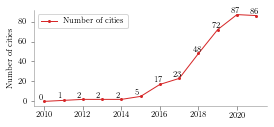

In [18]:
import matplotlib
latexify(columns=2,fig_height=1.8,fig_width=3.8)

year_range = range(2010,2022,1)

count = [years[each] for each in year_range]
fig,ax = plt.subplots()
fig.tight_layout()

ax.plot(year_range,count,"-o",linewidth=1,markersize=2,color="tab:red",label="Number of cities")
for x,y in zip(year_range,count):
    ax.annotate(y,xy=(x-0.3,y+2))


format_axes(ax)
#ax.set_yticks(np.arange(0,91,45))

ax.set(ylabel="Number of cities");
#ax.set_title("")
ax.legend()

plt.show()


In [19]:
fig.savefig("../figures/fig1_no_of_cities_with_avl_stns.pdf",bbox_inches="tight")